## Machine Learning
### Project: Diabetes classification Using

**@author : Kevin KURTZ**, <br>

**@email : kevin.kurtz@efrei.net** <br>


#### Dependancies :

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#### Dataset :
Let's start by loading the Pima Indians Diabetes Dataset. For this, I use my own github repository to load the dataset.

In [2]:

df = pd.read_csv("https://raw.githubusercontent.com/ktzkvin/Diabetes-Prediction-ML/refs/heads/main/data-diabetes.csv")

# ---- Another way is to load the dataset from a local file :
# df = pd.read_csv("data-diabetes.csv")

## 1. Data Preprocessing

### 1.1 Analyze the dataset to understand the distribution of classes:

In [3]:

# Check number of rows and columns
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

# Display basic statistics
df.describe()

Number of rows:  768
Number of columns:  9


Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [8]:
# Show general info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


As we can see, the dataset has **768 rows** and **9 columns**. Also, it seems there are **no missing values** in the dataset.

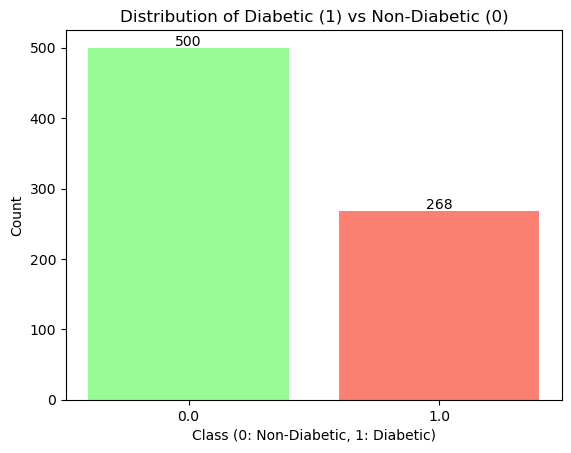

In [11]:

%matplotlib inline

class_counts = df['Outcome'].value_counts()

ax = sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Diabetic (1) vs Non-Diabetic (0)')
plt.xlabel('Class (0: Non-Diabetic, 1: Diabetic)')
plt.ylabel('Count')

# Adding the percentage for each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, f'{int(height)}', ha="center")

colors = ['palegreen', 'salmon']
plt.bar(class_counts.index, class_counts, color=colors)

plt.show()

As we can see, in this dataset, there are 500 Non-Diabetic patients and 268 Diabetic patients. This means that the dataset is a bit **imbalanced** (65% // 35% Diabetic).

#### Dataset Profiling with ydata-profiling

To get a quick overview of the dataset, we use **ydata-profiling**, which generates an interactive report with detailed statistics for each feature. 
Below is the profiling report for the **Pima Indians Diabetes Dataset**:


In [12]:
from ydata_profiling import ProfileReport 
 
profile = ProfileReport(df, title="Pima Indians Diabetes Dataset Profiling Report") 
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---
### 1.2 Handle missing values (replacing 0 by median values):

#### Why use the median to replace 0 values?

In medical datasets like this one, certain variables such as **Glucose**, **BloodPressure**, **SkinThickness**, **Insulin**, and **BMI** should not have a value of 0. These zeros likely represent missing or incorrect data rather than actual measurements. For instance, it's impossible for a living person to have a blood pressure of 0.

To handle this, we choose to replace these "0" values with the **median**. The median is more robust to outliers than the mean, which makes it a better choice in medical contexts where extreme values could distort the average. Using the median helps maintain the accuracy of the dataset without introducing unnecessary bias from outliers. Also, deleting these rows is not a good option because it would result in a significant loss of data, since there are only 768 rows in the dataset.

Additionally, we calculate separate medians for **Outcome 0** (non-diabetic) and **Outcome 1** (diabetic). This ensures that the data imputation is more accurate and reflects the underlying distribution of each class. This approach is more effective than using a single median for the entire dataset.

In [9]:
# Splitting the dataset based on the 'Outcome' (0 = No Diabetes, 1 = Diabetes)
df_outcome_0 = df[df['Outcome'] == 0]
df_outcome_1 = df[df['Outcome'] == 1]

# Calculating the medians for each Outcome group
median_outcome_0 = df_outcome_0[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].median()
median_outcome_1 = df_outcome_1[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].median()

# Function to replace "0" values with the median based on Outcome
def impute_with_median(row, median_0, median_1):
    if row['Outcome'] == 0:
        for col in median_0.index:
            if row[col] == 0:
                row[col] = median_0[col]
    else:
        for col in median_1.index:
            if row[col] == 0:
                row[col] = median_1[col]
    return row

# Apply the function to the dataset
df = df.apply(impute_with_median, axis=1, args=(median_outcome_0, median_outcome_1))

# Check the dataset again after imputation
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000      768.00000  768.000000   
mean      3.845052  121.677083      72.378906       27.43099   91.783854   
std       3.369578   30.464161      12.104431        9.32146  108.121136   
min       0.000000   44.000000      24.000000        7.00000    0.000000   
25%       1.000000   99.750000      64.000000       21.00000   39.000000   
50%       3.000000  117.000000      72.000000       27.00000   39.000000   
75%       6.000000  140.250000      80.000000       32.00000  127.250000   
max      17.000000  199.000000     122.000000       99.00000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.433919                  0.471876   33.240885    0.348958  
std      6.880664                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.050000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

---
### 1.3 Encode categorical features appropriately (verifying all columns are numerical):

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


All features are already numerical, so **no encoding is necessary**.

## 2. Feature Selection


As part of the feature selection, we could, in a first way, check which columns we could remove from the dataset, thanks to the correlation matrix. <br>
In a second way, we could use the PCA method to reduce the number of features. <br>

### 2.1 Correlation Matrix:
We can now create a correlation matrix to analyze the relationships between features and identify potential redundant variables.

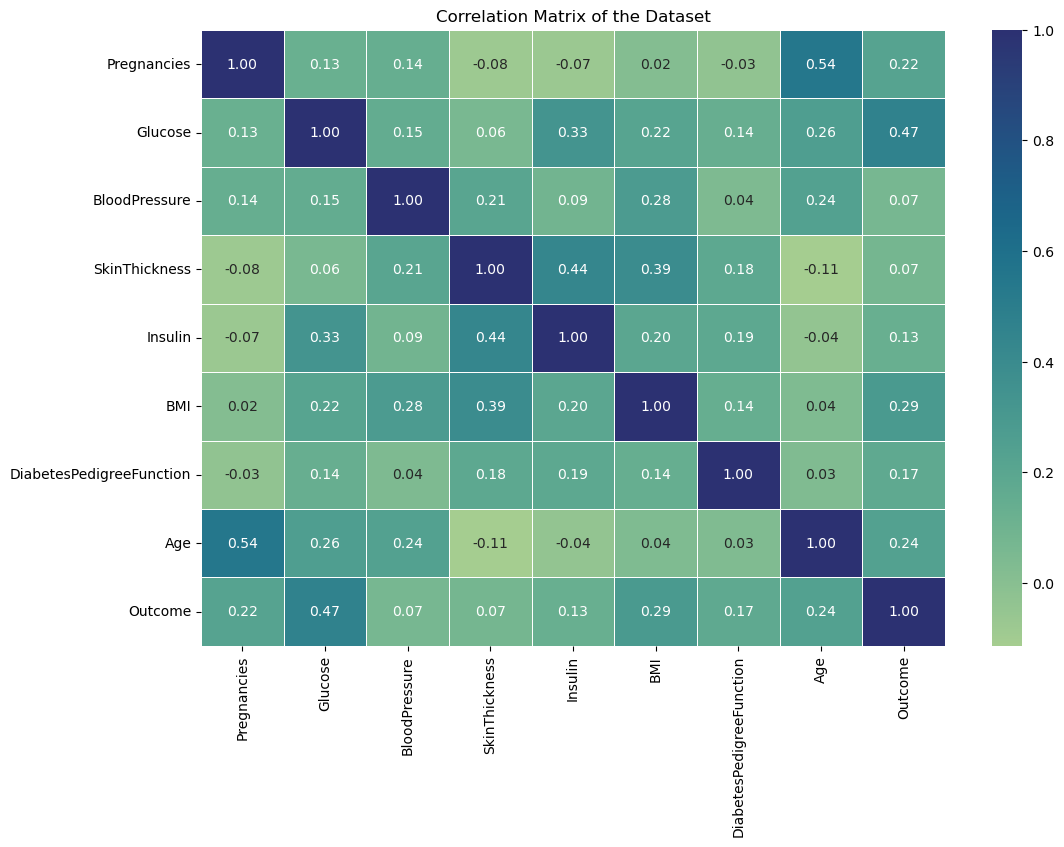

In [7]:
# Correlation Matrix
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='crest', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of the Dataset')

plt.show()

The graph above shows the **correlation matrix** of the features in the dataset.

Some important points:

1. **Glucose** has a good correlation with **Outcome** (**0.47**). This means higher glucose levels are linked to a higher chance of diabetes.

2. **Age** is strongly correlated with **Pregnancies** (**0.54**), which makes sense since older women have had more pregnancies.

3. **BMI** and **SkinThickness** are somewhat correlated (**0.39**), showing they might have some overlap in information.

4. Other features like **BloodPressure** and **Insulin** have lower correlations with **Outcome**, meaning they might not be as important for predicting diabetes.

Despite some lower correlations, we will keep all features because each feature carries important medical information.

---

#### Why don't we use PCA ?

While PCA is a useful technique for reducing the number of features in a dataset, it's not necessary in this case because:

- **Few features**: We only have 8 features, so we don’t need to reduce them. PCA is useful when we have more features, like 100 or +.

- **Keeping the meaning**: PCA mixes the features together, which makes it harder to understand. In medical data, it is important to know exactly which feature (like glucose or blood pressure) is causing diabetes.

- **Not complex enough**: PCA is not likely to make the model much better because the dataset is not very complex. It would also make the model harder to explain.

---

### 2.2 Normalize the dataset:

However, we could already make the normalization of the data to have a better performance of the model, and since the dataset contains variables with diff scales, it's necessary to normalize them before training models.

In [13]:
# Normalize the dataset (except for 'Outcome')
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=df.columns[:-1])

# Keep the 'Outcome' column in the scaled dataframe
df_scaled['Outcome'] = df['Outcome']

df_scaled.describe()


Pregnancies       Glucose  BloodPressure  SkinThickness       Insulin  \
count  7.680000e+02  7.680000e+02   7.680000e+02   7.680000e+02  7.680000e+02   
mean  -8.789266e-17  1.665335e-16   9.251859e-18   1.237436e-16 -7.256927e-17   
std    1.000652e+00  1.000652e+00   1.000652e+00   1.000652e+00  1.000652e+00   
min   -1.141852e+00 -2.551447e+00  -3.999398e+00  -2.193251e+00 -8.494516e-01   
25%   -8.448851e-01 -7.202356e-01  -6.926692e-01  -6.903618e-01 -4.885100e-01   
50%   -2.509521e-01 -1.536274e-01  -3.132350e-02  -4.626640e-02 -4.885100e-01   
75%    6.399473e-01  6.100618e-01   6.300222e-01   4.904798e-01  3.282361e-01   
max    3.906578e+00  2.539814e+00   4.102087e+00   7.682879e+00  6.980205e+00   

                BMI  DiabetesPedigreeFunction           Age     Outcome  
count  7.680000e+02              7.680000e+02  7.680000e+02  768.000000  
mean   3.777071e-15              1.905883e-15  2.081668e-16    0.348958  
std    1.000652e+00              1.000652e+00  1.000652e+00    0.476951  
min   -2.070032e+00             -1.189553e+00 -1.041549e+00    0.000000  
25%   -7.175375e-01             -6.889685e-01 -7.862862e-01    0.000000  
50%   -5.583320e-02             -3.001282e-01 -3.608474e-01    0.000000  
75%    6.058711e-01              4.662269e-01  6.602056e-01    1.000000  
max    5.041471e+00              5.883565e+00  4.063716e+00    1.000000

## 3. Model Selection

Now, we can start building the machine learning model. We will use the following algorithms:

1. *Decision Tree*

2. *Logistic Regression*

3. *KNN*

4. *Multi-layer Perceptron (MLP)*


---
#### Preparing the dataset for training

Before building our machine learning models, we need to **split** the dataset into features (X) and the target variable (y). Here, **X** contains all the input features (everything except 'Outcome') and **y** contains the **Outcome**, which indicates if a person has diabetes (1) or not (0).

In [19]:
# Prepare the dataset
X = df_scaled.drop(columns='Outcome')
y = df_scaled['Outcome']

After separating the features and target, we split the dataset into **training** (80%) and **testing** (20%) sets using **train_test_split**. This step is crucial because the model needs to be trained on one part of the data and tested on another to evaluate its performance.

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---
### 3.1 Decision Tree:

In [82]:
# Decision Tree
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)

print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree - Classification Report:\n\n", classification_report(y_test, y_pred_tree))

Decision Tree - Accuracy: 0.8636363636363636
Decision Tree - Classification Report:

               precision    recall  f1-score   support

         0.0       0.90      0.89      0.89        99
         1.0       0.80      0.82      0.81        55

    accuracy                           0.86       154
   macro avg       0.85      0.85      0.85       154
weighted avg       0.86      0.86      0.86       154



- **Accuracy: 86.36%**

The Decision Tree model performed well with an accuracy of **86.36%**. It shows a good balance between precision and recall for both classes, especially for the non-diabetic class (0.90 precision and 0.89 recall). <br>
Overall, it outperforms most models and ranks **second** in terms of accuracy in this project.


#### Decision Tree Visualization

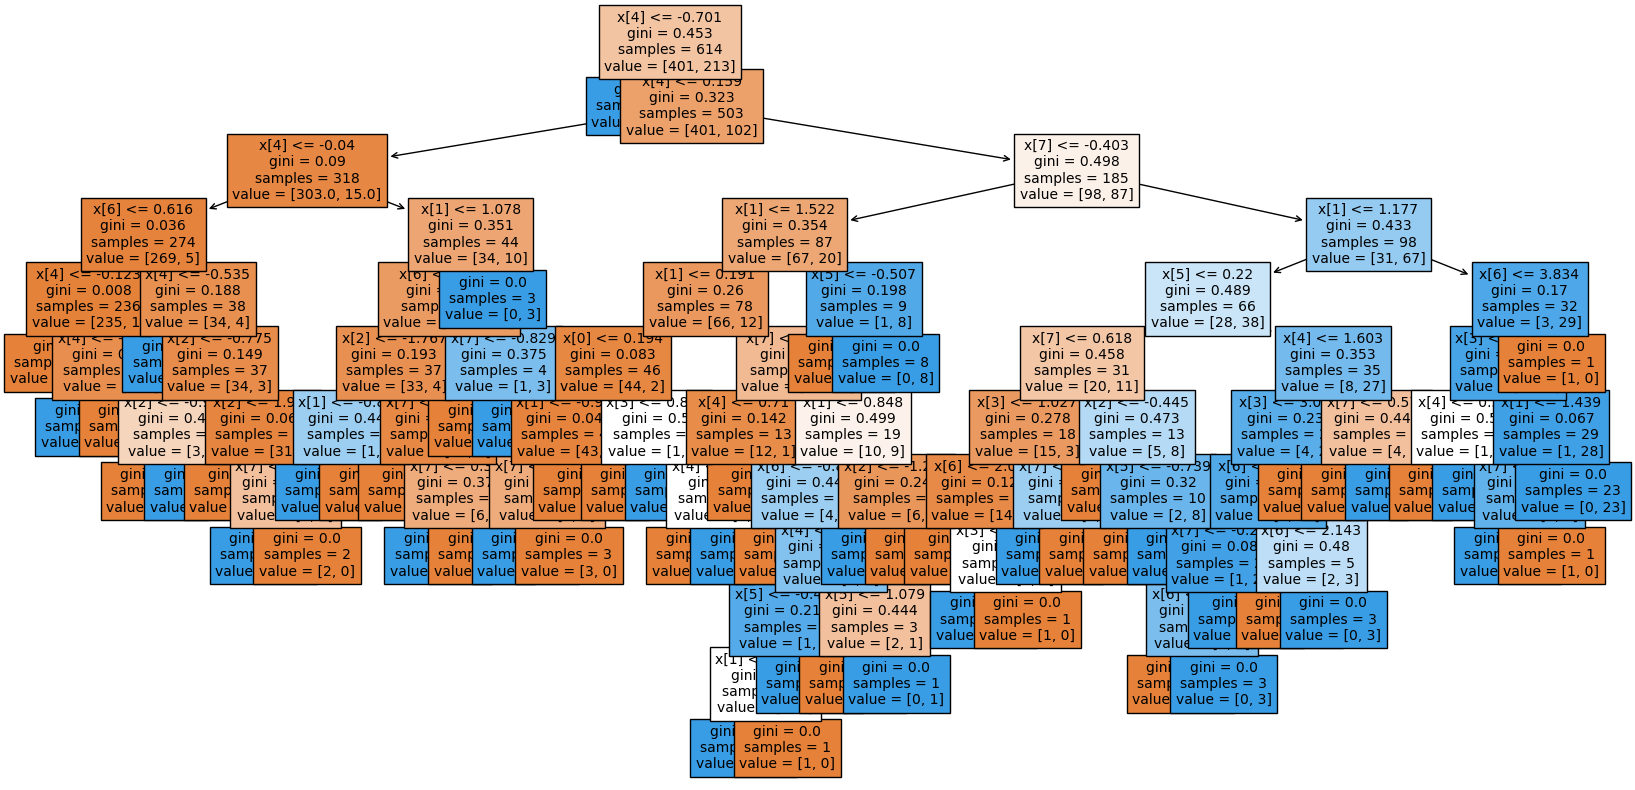

In [94]:
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf_tree, filled=True, fontsize=10)

plt.show()

As we can see, the decision tree is a bit messy and hard to read. It's difficult to understand the rules and decisions made by the model. This is why we will explore how to modify hyperparameters, especially using GridSearch, in the 5th section.

---
### 3.2 Logistic Regression:

In [55]:
# Logistic Regression
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression - Classification Report:\n\n", classification_report(y_test, y_pred_lr))

Logistic Regression - Accuracy: 0.7792207792207793
Logistic Regression - Classification Report:

               precision    recall  f1-score   support

         0.0       0.82      0.85      0.83        99
         1.0       0.71      0.65      0.68        55

    accuracy                           0.78       154
   macro avg       0.76      0.75      0.76       154
weighted avg       0.78      0.78      0.78       154



- **Accuracy: 77.92%**

The Logistic Regression model achieved an accuracy of **77.92%**, which is lower than the Decision Tree. While it performs decently for the non-diabetic class, with a precision of **0.82**, it struggles with the diabetic class, where precision drops to **0.71**. This indicates that Logistic Regression may not capture the complexity of this dataset as well as some other models.

---
### 3.3 KNN:

In [52]:
# KNN
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)

print("KNN - Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN - Classification Report:\n\n", classification_report(y_test, y_pred_knn))

KNN - Accuracy: 0.7922077922077922
KNN - Classification Report:

               precision    recall  f1-score   support

         0.0       0.83      0.86      0.84        99
         1.0       0.73      0.67      0.70        55

    accuracy                           0.79       154
   macro avg       0.78      0.77      0.77       154
weighted avg       0.79      0.79      0.79       154



- **Accuracy: 79.22%**

The KNN model performs slightly better than Logistic Regression with an accuracy of **79.22%**. It has a good balance between precision and recall, but, like Logistic Regression, it still struggles with the diabetic class, where precision is **0.73**. However, the model ranks **fourth** overall in accuracy, showing a decent but not the best performance.

--- 
### 3.4 Multi-layer Perceptron (MLP):

In [49]:
# MLP
clf_mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)
clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)

print("MLP Classifier - Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("MLP Classifier - Classification Report:\n\n", classification_report(y_test, y_pred_mlp))

MLP Classifier - Accuracy: 0.8441558441558441
MLP Classifier - Classification Report:

               precision    recall  f1-score   support

         0.0       0.86      0.91      0.88        99
         1.0       0.82      0.73      0.77        55

    accuracy                           0.84       154
   macro avg       0.84      0.82      0.83       154
weighted avg       0.84      0.84      0.84       154



- **Accuracy: 84.42%**

The MLP model performs well with an accuracy of **84.42%**, which places it **third** after the Decision Tree. The MLP shows strong performance for both classes, with good precision and recall scores. The slightly lower accuracy compared to the Decision Tree may be due to the complexity of tuning neural networks, but overall, it is one of the stronger models in this comparison.


---
### 3.5 Random Forest:

In [91]:
# Random Forest
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest - Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest - Accuracy: 0.8766233766233766
Random Forest - Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.91        99
         1.0       0.86      0.78      0.82        55

    accuracy                           0.88       154
   macro avg       0.87      0.86      0.86       154
weighted avg       0.88      0.88      0.88       154



- **Accuracy: 87.66%**

The Random Forest model achieved an accuracy of **87.66%**, which is the **highest** among all the models tested so far. It performs exceptionally well for the non-diabetic class (0), with a recall of 0.93, meaning it correctly identifies the majority of non-diabetic patients. Overall, Random Forst ranks **first** in terms of accuracy and general performance for this project.

---
#### Feature Importance with Random Forest

Since the Random Forest model performed the best, we can analyze the **feature importance** to understand which variables have the most impact on predicting diabetes. This information can be valuable for medical professionals to identify key risk factors for diabetes.

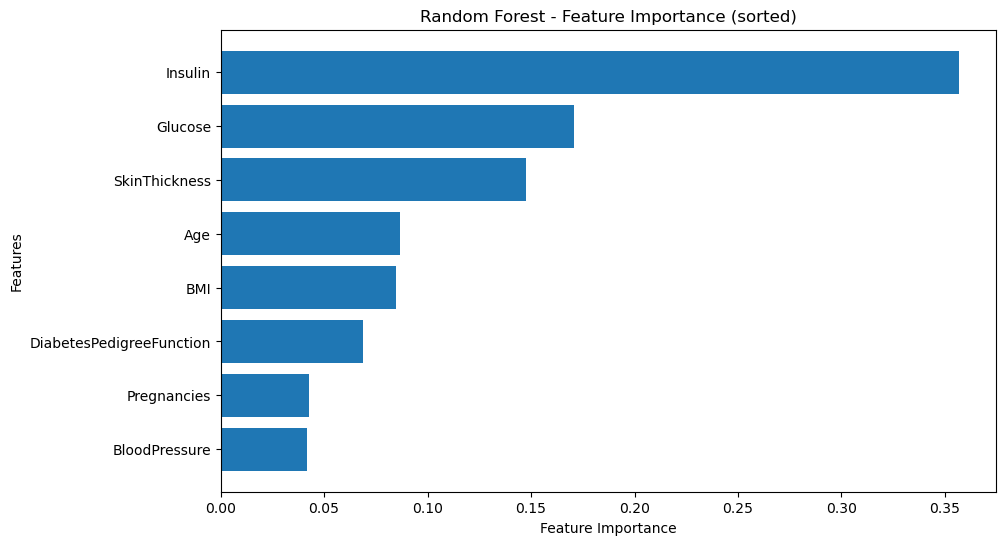

In [92]:
# Feature Importance analysis
rf_feature_importance = clf_rf.feature_importances_
features = X_train.columns

sorted_idx_rf = np.argsort(rf_feature_importance)
sorted_features_rf = pd.DataFrame({'Feature': features[sorted_idx_rf], 'Importance': rf_feature_importance[sorted_idx_rf]})

plt.figure(figsize=(10, 6))
plt.barh(sorted_features_rf['Feature'], sorted_features_rf['Importance'], align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest - Feature Importance (sorted)")

plt.show()
